<a href="https://colab.research.google.com/github/lblogan14/master_tensorflow_keras/blob/master/ch5_mlp_tensorflow_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Prerequisites

In [71]:
import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import pandas as pd
print("Pandas:{}".format(pd.__version__))

import math
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10
print("Matplotlib:{}".format(mpl.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

import keras
print("Keras:{}".format(keras.__version__))

NumPy:1.14.6
Pandas:0.22.0
Matplotlib:2.1.2
TensorFlow:1.12.0-rc2
Keras:2.2.4


In [76]:
!pip3 install imageio
DATASETSLIB_HOME = '../datasetslib'
import sys
if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)
%reload_ext autoreload
%autoreload 2
import datasetslib

from datasetslib import util as dsu

    100% |████████████████████████████████| 3.3MB 8.3MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio


#MultiLayer Perceptron
![](https://dz13w8afd47il.cloudfront.net/graphics/9781788292061/graphics/8da1b74b-a7ed-4558-b409-87c66868bc2f.png)

#MLP for image classification

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist', one_hot=True)

x_train = mnist.train.images
x_test = mnist.test.images
y_train = mnist.train.labels
y_test = mnist.test.labels

num_outputs = 10
num_inputs = 28*28

##TensorFlow-based MLP for MNIST classification
create three helper functions

In [0]:
tf.reset_default_graph()

`mlp()` builds the network layers and returns a `layer` object that contains the MLP network

In [0]:
def mlp(x, num_inputs, num_outputs, num_layers, num_neurons):
  w = []
  b = []
  for i in range(num_layers):
    # weights
    w.append(tf.Variable(tf.random_normal([num_inputs if i==0 else num_neurons[i-1],
                                           num_neurons[i]]),
                         name='w_{0:04d}'.format(i)
                        )
            )
    # biases
    b.append(tf.Variable(tf.random_normal([num_neurons[i]]),
                         name='b_{0:04d}'.format(i)
                        )
            )
    
  w.append(tf.Variable(tf.random_normal([num_neurons[num_layers-1] if num_layers>0 else num_inputs,
                                         num_outputs]),
                       name='w_out')
          )
  b.append(tf.Variable(tf.random_normal([num_outputs]),
                       name='b_out')
          )
  
  # x is input layer
  layer = x
  # hidden layers
  for i in range(num_layers):
    layer = tf.nn.relu(tf.matmul(layer, w[i]) + b[i])
  # output layers
  layer = tf.matmul(layer, w[num_layers]) + b[num_layers]
  return layer

`mnist_batch)func()` wraps the TensorFlow's batch function for the MNIST dataset to provide the next batch of images

In [0]:
def mnist_batch_func(batch_size=100):
  x_batch, y_batch = mnist.train.next_batch(batch_size)
  return [x_batch, y_batch]

`tensorflow_classification` trains and evaluates the model

In [0]:
def tensorflow_classification(n_epochs, n_batches, batch_size, batch_func, 
                              model, optimizer, loss, accuracy_function,
                              x_test, y_test):
  with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
      epoch_loss = 0.0
      for batch in range(n_batches):
        x_batch, y_batch = batch_func(batch_size)
        feed_dict = {x:x_batch, y:y_batch}
        _, batch_loss = tfs.run([optimizer, loss], feed_dict)
        epoch_loss += batch_loss
      average_loss = epoch_loss / n_batches
      print('epoch: {0:04d}    loss = {1:0.6f}'.format(epoch, average_loss))
    
    feed_dict = {x: x_test, y:y_test}
    accuracy_score = tfs.run(accuracy_function, feed_dict=feed_dict)
    print('accuracy={0:.8f}'.format(accuracy_score))

Now we can define input, output, and other parameters,

In [0]:
tf.reset_default_graph()

In [0]:
num_layers = 0
num_neurons = []
learning_rate = 0.01
n_epochs = 50
batch_size = 100
n_batches = int(mnist.train.num_examples / batch_size)

# input images
x = tf.placeholder(dtype=tf.float32, shape=[None, num_inputs], name='x')
# target output
y = tf.placeholder(dtype=tf.float32, shape=[None, num_outputs], name='y')

define loss and optimization functions,

In [0]:
model = mlp(x=x, num_inputs=num_inputs, num_outputs=num_outputs,
                 num_layers=num_layers, num_neurons=num_neurons)

# loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=y))

# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

predictions_check = tf.equal(tf.argmax(model, 1), tf.argmax(y, 1))
accuracy_function = tf.reduce_mean(tf.cast(predictions_check, tf.float32))

When the `tf.nn.softmax_cross_entropy_with_logits()` function is used,
make sure that the output is unscaled and has not been passed through
the `softmax` activation function. This function internally uses *softmax* to
scale the output.

Everything is defined now. Let's run the last step,

In [0]:
tensorflow_classification(n_epochs=n_epochs,
                          n_batches=n_batches,
                          batch_size=batch_size,
                          batch_func=mnist_batch_func,
                          model=model,
                          optimizer=optimizer,
                          loss=loss,
                          accuracy_function=accuracy_function,
                          x_test=x_test,
                          y_test=y_test
                         )

The single neuron network with no hidden layers slowly reduces the loss from 8.5 to 0.66 over 50
iterations, finally getting an accuracy of almost 86 percent.

We can try to increase this performance by adding more hidden layers and more hidden neurons within each hidden layer.

First, use one hidden layer with 8 hidden neurons,

In [0]:
tf.reset_default_graph()

In [0]:
num_layers = 1
num_neurons = []
for i in range(num_layers):
  num_neurons.append(8)

In [0]:
# everything else stay the same
learning_rate = 0.01
n_epochs = 50
batch_size = 100
n_batches = int(mnist.train.num_examples / batch_size)

# input images
x = tf.placeholder(dtype=tf.float32, shape=[None, num_inputs], name='x')
# target output
y = tf.placeholder(dtype=tf.float32, shape=[None, num_outputs], name='y')

model = mlp(x=x, num_inputs=num_inputs, num_outputs=num_outputs,
                 num_layers=num_layers, num_neurons=num_neurons)

# loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=y))

# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

predictions_check = tf.equal(tf.argmax(model, 1), tf.argmax(y, 1))
accuracy_function = tf.reduce_mean(tf.cast(predictions_check, tf.float32))

In [0]:
tensorflow_classification(n_epochs=n_epochs,
                          n_batches=n_batches,
                          batch_size=batch_size,
                          batch_func=mnist_batch_func,
                          model=model,
                          optimizer=optimizer,
                          loss=loss,
                          accuracy_function=accuracy_function,
                          x_test=x_test,
                          y_test=y_test
                         )

The loss is reduced from 4.07 to 0.75.. The accuracy is about 76%... Even worse..

Let's add one more hidden layer with 256 neurons in each hidden layer

In [0]:
tf.reset_default_graph()

In [0]:
num_layers = 2
num_neurons = []
for i in range(num_layers):
  num_neurons.append(256)

In [0]:
# everything else stay the same
learning_rate = 0.01
n_epochs = 50
batch_size = 100
n_batches = int(mnist.train.num_examples / batch_size)

# input images
x = tf.placeholder(dtype=tf.float32, shape=[None, num_inputs], name='x')
# target output
y = tf.placeholder(dtype=tf.float32, shape=[None, num_outputs], name='y')

model = mlp(x=x, num_inputs=num_inputs, num_outputs=num_outputs,
                 num_layers=num_layers, num_neurons=num_neurons)

# loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=y))

# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

predictions_check = tf.equal(tf.argmax(model, 1), tf.argmax(y, 1))
accuracy_function = tf.reduce_mean(tf.cast(predictions_check, tf.float32))

In [0]:
tensorflow_classification(n_epochs=n_epochs,
                          n_batches=n_batches,
                          batch_size=batch_size,
                          batch_func=mnist_batch_func,
                          model=model,
                          optimizer=optimizer,
                          loss=loss,
                          accuracy_function=accuracy_function,
                          x_test=x_test,
                          y_test=y_test
                         )

The loss is reduced from 56.6 to 0.003 while the accuracy is 93.2% now. Of course, the training time is longer than the previous two.

##Keras-based MLP for MNIST classification
All parameters used for TensorFlow example keep the same for Keras

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [0]:
tf.reset_default_graph()
keras.backend.clear_session()

Initialize all the parameters,

In [0]:
num_layers = 2
num_neurons = []
for i in range(num_layers):
  num_neurons.append(256)
  
learning_rate = 0.01
n_epochs = 50
batch_size = 100

Build the network,

In [0]:
model = Sequential()
model.add(Dense(units=num_neurons[0], activation='relu', input_shape=(num_inputs,)))
model.add(Dense(units=num_neurons[1], activation='relu'))
model.add(Dense(units=num_outputs, activation='softmax'))
model.summary()

Compile and train the network,

In [0]:
model.compile(loss='categorical_crossentropy', 
              optimizer=SGD(lr=learning_rate),
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs)

Evaluate the network,

In [0]:
score = model.evaluate(x_test, y_test)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

##TFLearn-based MLP for MNIST classification

In [0]:
!pip3 install tflearn

In [0]:
import tflearn

In [0]:
tf.reset_default_graph()

In [0]:
num_layers = 2
num_neurons = []
for i in range(num_layers):
    num_neurons.append(256)
    
learning_rate = 0.01
n_epochs = 50
batch_size = 100

Build the network,

In [0]:
# Build deep neural network
input_layer = tflearn.input_data(shape=[None, num_inputs])
dense1 = tflearn.fully_connected(input_layer, num_neurons[0], activation='relu')
dense2 = tflearn.fully_connected(dense1, num_neurons[1], activation='relu')
softmax = tflearn.fully_connected(dense2, num_outputs, activation='softmax')

Define the optimizer function, neural network, and MLP model (known as `DNN`
in TFLearn) using the `DNN` built in the last step

In [0]:
optimizer = tflearn.SGD(learning_rate=learning_rate)
net = tflearn.regression(softmax, optimizer=optimizer, 
                         metric=tflearn.metrics.Accuracy(), 
                         loss='categorical_crossentropy')
model = tflearn.DNN(net)

Train the model,

In [0]:
model.fit(x_train, y_train, 
          n_epoch=n_epochs, batch_size=batch_size, 
          show_metric=True, run_id='dense_model')

In [0]:
score = model.evaluate(X_test, Y_test)
print('Test accuracy:', score[0])

##Summary
The code in TensorFlow is very detailed and lengthy as compared to Keras
and TFLearn. The high-level libraries make it easier for us to build and train neural network
models.

#MLP for time series regression

## Load and Prepare dataset

In [69]:
from google.colab import drive
drive.mount('/content/drive') #add drive content to the notebook

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [70]:
'''Locate the directory which has the dataset'''
%cd /content/drive/My' 'Drive/Colab' 'Notebooks/Mastering_TensorFlow/data

/content/drive/My Drive/Colab Notebooks/Mastering_TensorFlow/data


In [0]:
dataframe = pd.read_csv('./dataset/international-airline-passengers.csv',
                        usecols=[1], header=0)
dataset = dataframe.values
dataset = dataset.astype('float32')

Split the dataset into test and train sets

In [77]:
train, test = dsu.train_test_split(dataset, train_size=0.67)
print(len(train), len(test))

96 48


For time series regression, we convert the dataset to build a supervised data set.

We use a lag of two time steps in this example. We set `n_x` to `2` and the `mvts_to_xy()` function returns the input and output (X and Y) train and test sets such that `X` has values for time `{t-1,t}` in two columns and Y has values for time `{t+1}` in one column.

In [0]:
# reshape to X=t-1,t and Y=t+1
n_x = 2
n_y = 1

x_train, y_train, x_test, y_test = dsu.mvts_to_xy(train, test, n_x=n_x, n_y=n_y)

In [81]:
print(x_train.shape, y_train.shape)

(94, 2) (94, 1)


The learning algorithm assumes that values at time t+1 can be learned by finding the relationship between values for time {t-1, t, t+1}.

##Keras model

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [0]:
tf.reset_default_graph()
keras.backend.clear_session()

In [0]:
num_layers = 2
num_neurons = [8, 8]
n_epochs = 50
batch_size = 2

In [85]:
model = Sequential()
model.add(Dense(num_neurons[0], activation='relu', input_shape=(n_x,)))
model.add(Dense(num_neurons[1], activation='relu',))
model.add(Dense(units=1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.compile(loss='mse', optimizer='adam')
model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs)

Epoch 1/50
94/94 [==============================] - 0s 2ms/step - loss: 52933.6246
Epoch 2/50
94/94 [==============================] - 0s 494us/step - loss: 38787.3071
Epoch 3/50
94/94 [==============================] - 0s 478us/step - loss: 28105.6690
Epoch 4/50
94/94 [==============================] - 0s 502us/step - loss: 19014.1782
Epoch 5/50
94/94 [==============================] - 0s 496us/step - loss: 11100.9683
Epoch 6/50
94/94 [==============================] - 0s 468us/step - loss: 5301.2312
Epoch 7/50
94/94 [==============================] - 0s 514us/step - loss: 2331.8725
Epoch 8/50
94/94 [==============================] - 0s 519us/step - loss: 1272.7843
Epoch 9/50
94/94 [==============================] - 0s 474us/step - loss: 1032.7865
Epoch 10/50
94/94 [==============================] - 0s 511us/step - loss: 983.0500
Epoch 11/50
94/94 [==============================] - 0s 524us/step - loss: 964.8280
Epoch 12/50
94/94 [==============================] - 0s 516us/step - loss

In [87]:
score = model.evaluate(x_test, y_test)
print('\nTest mse:', score)
print('Test rmse:', np.sqrt(score))

46/46 [==============================] - 0s 553us/step

Test mse: 2959.5584769870925
Test rmse: 54.401824206427975


Plot the data and the prediction,

In [0]:
# make predictions
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# shift train predictions for plotting
y_train_pred_plot = np.empty_like(dataset)
y_train_pred_plot[:,:] = np.nan
y_train_pred_plot[n_x-1:len(y_train_pred)+n_x-1, :] = y_train_pred

# shift test predictions for plotting
y_test_pred_plot = np.empty_like(dataset)
y_test_pred_plot[:,:] = np.nan
y_test_pred_plot[len(y_train_pred)+(n_x*2)-1:len(dataset)-1, :] = y_test_pred

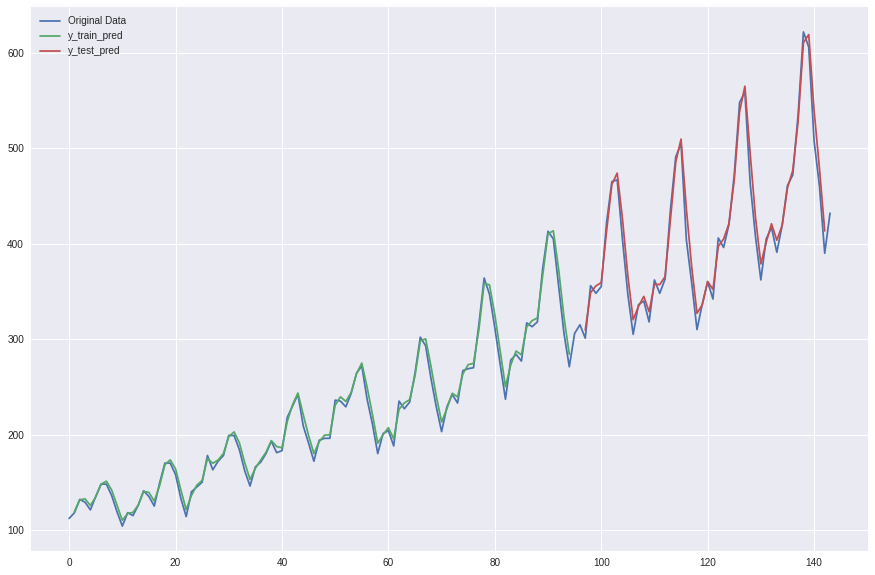

In [90]:
plt.plot(dataset, label='Original Data')
plt.plot(y_train_pred_plot, label='y_train_pred')
plt.plot(y_test_pred_plot, label='y_test_pred')
plt.legend()